# Import data

In [1]:
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()

,RunId,TargetModule,Algorithm,AlgorithmIterations,SearchTime,TuningParameters,Coverage,CoverageTimeline_T1,CoverageTimeline_T2,CoverageTimeline_T3,...,CoverageTimeline_T291,CoverageTimeline_T292,CoverageTimeline_T293,CoverageTimeline_T294,CoverageTimeline_T295,CoverageTimeline_T296,CoverageTimeline_T297,CoverageTimeline_T298,CoverageTimeline_T299,CoverageTimeline_T300
0,flutils.decorators#247,flutils.decorators,DYNAMOSA_RL,1513,300064136954,TestChangeProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
1,codetiming._timer#100,codetiming._timer,DYNAMOSA_RL,1001,300064143210,Elite,0.888889,0.555556,0.555556,0.629630,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
2,codetiming._timer#222,codetiming._timer,DYNAMOSA_RL,1516,300085846117,StatementInsertionProbability,0.888889,0.444444,0.666667,0.696566,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
3,flutils.decorators#327,flutils.decorators,DYNAMOSA_RL,1510,300133832198,TestInsertProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,httpie.output.formatters.headers#50,httpie.output.formatters.headers,DYNAMOSA_RL,2089,300206714135,ChromosomeLength,0.600000,0.600000,0.600000,0.600000,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000


# Coverage Distribution plot

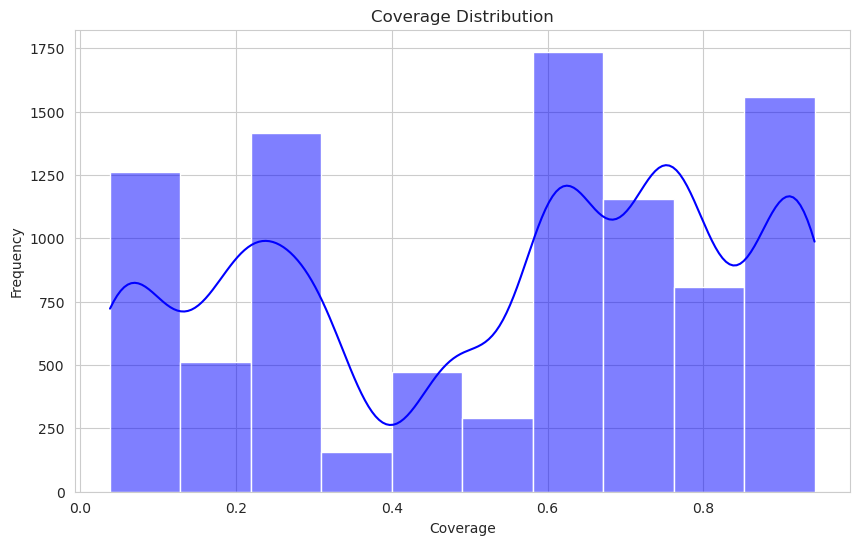

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

# Style
sb.set_style('whitegrid')

plt.figure(figsize=(10,6))
sb.histplot(data['Coverage'], bins=10, kde=True, color='blue')
plt.title('Coverage Distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()

In [45]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule)'
model_spec = formulaic.model_matrix(model_formula, data=data)

#group_idx = pd.Categorical(data['TargetModule']).codes
#group_idx
model_spec.rhs.iloc[:, :20]

""
0
1
2
3
4
...
9355
9356
9357
9358


In [16]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=model_spec.rhs.shape[1])
    
    # Deterministic transformations for logit(pi)
    logit_p = pm.math.dot(model_spec.rhs, a_m)
    
    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_m, theta]


/home/erik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


Model building complete.


In [41]:
import arviz as az
column_names = model_spec.rhs.columns
# Iterate over the column names and print out the mapping
for i, name in enumerate(column_names):
    category = name.split('[')[-1].rstrip(']')
    print(f'a_m[{i}]: {category}')


def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary



a_m[0]: T.codetiming._timer
a_m[1]: T.flutils.decorators
a_m[2]: T.flutils.namedtupleutils
a_m[3]: T.flutils.packages
a_m[4]: T.flutils.setuputils.cmd
a_m[5]: T.httpie.output.formatters.headers
a_m[6]: T.httpie.plugins.base
a_m[7]: T.mimesis.builtins.da
a_m[8]: T.py_backwards.transformers.base
a_m[9]: T.py_backwards.transformers.dict_unpacking
a_m[10]: T.py_backwards.transformers.return_from_generator
a_m[11]: T.py_backwards.transformers.yield_from
a_m[12]: T.py_backwards.utils.helpers
a_m[13]: T.pymonet.immutable_list
a_m[14]: T.pymonet.maybe
a_m[15]: T.pymonet.validation
a_m[16]: T.pypara.accounting.journaling
a_m[17]: T.pytutils.lazy.lazy_import
a_m[18]: T.pytutils.python
a_m[19]: T.sanic.config
a_m[20]: T.sanic.helpers
a_m[21]: T.sanic.mixins.signals
a_m[22]: T.thonny.plugins.pgzero_frontend
a_m[23]: T.typesystem.tokenize.positional_validation


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],0.873,0.003,0.869,0.877,0.000,0.000,12222.0,2836.0,1.0
a_m[1],0.663,0.004,0.657,0.668,0.000,0.000,10990.0,2883.0,1.0
a_m[2],0.933,0.002,0.930,0.935,0.000,0.000,10530.0,2889.0,1.0
a_m[3],0.052,0.002,0.049,0.054,0.000,0.000,9055.0,2867.0,1.0
a_m[4],0.077,0.002,0.074,0.080,0.000,0.000,11094.0,3096.0,1.0
a_m[5],0.598,0.004,0.592,0.603,0.000,0.000,12113.0,3003.0,1.0
a_m[6],0.747,0.003,0.742,0.753,0.000,0.000,13172.0,2694.0,1.0
a_m[7],0.793,0.003,0.788,0.798,0.000,0.000,13837.0,3021.0,1.0
a_m[8],0.279,0.003,0.273,0.284,0.000,0.000,10633.0,2697.0,1.0
a_m[9],0.140,0.003,0.136,0.144,0.000,0.000,10448.0,2917.0,1.0


array([[<Axes: title={'center': 'a_m_prob'}>,
        <Axes: title={'center': 'a_m_prob'}>]], dtype=object)

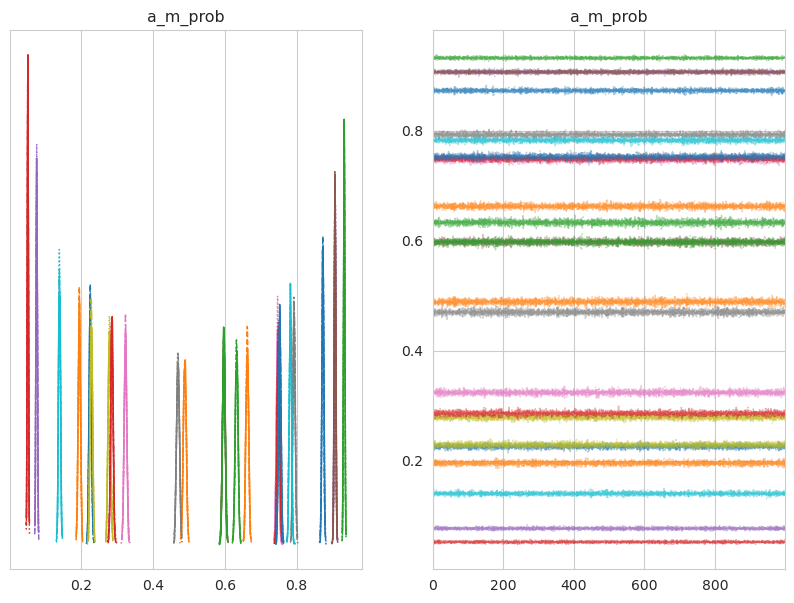

In [29]:
az.plot_trace(posterior_dict, var_names=['a_m_prob'], figsize=(10, 7))

In [3]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
model_spec.rhs.iloc[:, 24:]

,"C(TuningParameters, Treatment(reference='NONE'))[T.ChangeParameterProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.ChromosomeLength]","C(TuningParameters, Treatment(reference='NONE'))[T.CrossoverRate]","C(TuningParameters, Treatment(reference='NONE'))[T.Elite]","C(TuningParameters, Treatment(reference='NONE'))[T.Population]","C(TuningParameters, Treatment(reference='NONE'))[T.RandomPerturbation]","C(TuningParameters, Treatment(reference='NONE'))[T.StatementInsertionProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestChangeProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestDeleteProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestInsertProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestInsertionProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TournamentSize]"
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,0,0,0,0,1,0,0,0,0,0,0,0
9356,0,0,0,0,1,0,0,0,0,0,0,0
9357,0,0,0,0,0,1,0,0,0,0,0,0
9358,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=24)
    beta_p = pm.Normal('beta_p', mu=0, sigma = 0.5, shape= 12)
    
    # Deterministic transformations for logit(pi)
    logit_a = pm.math.dot(model_spec.rhs.iloc[:, :24], a_m)
    logit_beta = pm.math.dot(model_spec.rhs.iloc[:, 24:], beta_p)
    combined = logit_a + logit_beta

    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_m, beta_p, theta]


/home/erik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.


Model building complete.


In [7]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['beta_p'] = trace.posterior['beta_p'].values #log_odds_to_or(trace.posterior['beta_p'].values)

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary




,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],0.873,0.003,0.868,0.879,0.000,0.000,1484.0,2419.0,1.0
a_m[1],0.663,0.005,0.654,0.672,0.000,0.000,1029.0,1716.0,1.0
a_m[2],0.933,0.002,0.929,0.937,0.000,0.000,1946.0,2019.0,1.0
a_m[3],0.052,0.002,0.049,0.055,0.000,0.000,2402.0,2864.0,1.0
a_m[4],0.077,0.002,0.073,0.081,0.000,0.000,2031.0,2244.0,1.0
a_m[5],0.598,0.005,0.589,0.608,0.000,0.000,965.0,1535.0,1.0
a_m[6],0.748,0.004,0.739,0.756,0.000,0.000,1202.0,1858.0,1.0
a_m[7],0.793,0.004,0.787,0.801,0.000,0.000,1230.0,2013.0,1.0
a_m[8],0.279,0.004,0.270,0.287,0.000,0.000,1154.0,1874.0,1.0
a_m[9],0.140,0.003,0.134,0.146,0.000,0.000,1555.0,1917.0,1.0


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'beta_p'}>,
        <Axes: title={'center': 'beta_p'}>]], dtype=object)

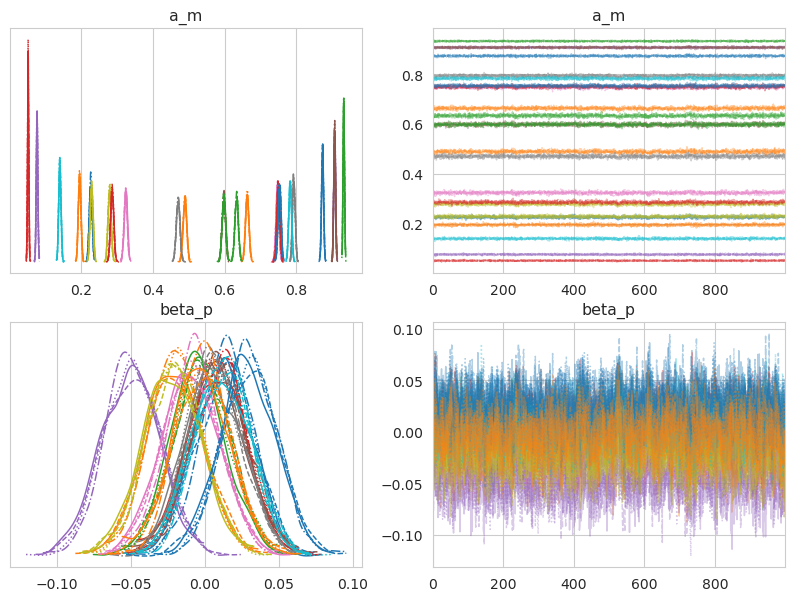

In [8]:
az.plot_trace(posterior_dict, var_names=['a_m', 'beta_p'], figsize=(10, 7))

In [9]:
az.to_netcdf(trace, "module_target_trace.nc")

'module_target_trace.nc'

In [129]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
module_matrix = model_spec.rhs.iloc[:, :24]
parameter_matrix = model_spec.rhs.iloc[:, 24:]

model_formula = 'Coverage ~ 0 +  C(TargetModule) : C(TuningParameters)'
model_spec = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in model_spec.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
model_spec.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
model_spec.rhs

,C(TargetModule)[T.codetiming._timer]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.flutils.decorators]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.flutils.namedtupleutils]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.flutils.packages]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.flutils.setuputils.cmd]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.httpie.output.formatters.headers]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.httpie.plugins.base]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.mimesis.builtins.da]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.py_backwards.transformers.base]:C(TuningParameters)[T.ChangeParameterProbability],C(TargetModule)[T.py_backwards.transformers.dict_unpacking]:C(TuningParameters)[T.ChangeParameterProbability],...,C(TargetModule)[T.pymonet.maybe]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.pymonet.validation]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.pypara.accounting.journaling]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.pytutils.lazy.lazy_import]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.pytutils.python]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.sanic.config]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.sanic.helpers]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.sanic.mixins.signals]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.thonny.plugins.pgzero_frontend]:C(TuningParameters)[T.TournamentSize],C(TargetModule)[T.typesystem.tokenize.positional_validation]:C(TuningParameters)[T.TournamentSize]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=24)
    beta_p = pm.Normal('beta_p', mu=0, sigma = 0.5, shape= 12)
    gamma_mp = pm.Normal('gamma_mp', mu=0, sigma = 0.5, shape=288)
    
    # Deterministic transformations for logit(pi)
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_beta = pm.math.dot(parameter_matrix, beta_p)
    logit_gamma = pm.math.dot(model_spec.rhs, gamma_mp)
    combined = logit_a + logit_beta + logit_gamma

    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_m, beta_p, gamma_mp, theta]


/home/erik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['beta_p'] = trace.posterior['beta_p'].values 
posterior_dict['gamma_mp'] = trace.posterior['gamma_mp'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary

In [ ]:
az.plot_trace(posterior_dict, var_names=['a_m', 'beta_p', 'gamma_mp'], figsize=(10, 7))

In [ ]:
idata = az.to_netcdf(trace, 'module_parameter_iteraction_nc')